<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/5_7_extract_features_from_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


stimuli_table_id = 'https://drive.google.com/open?id=1cVQXOhkaUYRJWgy65Zb1WQh0YJLEOAmH'.split('id=')[-1]

stimuli_ = drive.CreateFile({'id':stimuli_table_id})

stimuli_.GetContentFile('{}'.format('definitions.txt'))

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


# load the sentences

In [2]:
import pandas as pd
import numpy as np
# load the stimuli table
stimuli_table = pd.read_csv('definitions.txt', sep='\t').sort_values(['Likableness','Condition']).reset_index(drop = True)
sentences = [item + '.' for item in stimuli_table['Definition'].values]
sentences

['No siente compasión ante el sufrimiento ajeno o se deleita con él.',
 'Ni se emociona ni percibe los sentimientos de los demás.',
 'Cuando habla hace que los demás se sientan despreciados.',
 'No perdona nada a nadie ni muestra compasión alguna.',
 'Se desespera porque sólo puede ver el aspecto más negativo de las cosas.',
 'Se comporta como si la vida le maltratara todo el rato.',
 'Es muy inestable y reacciona ante las cosas de forma emocional y exagerada.',
 'Pierde la calma con facilidad y reacciona de forma agresiva ante los demás.',
 'Se siente triste o enfadado/a cuando no tiene lo mismo que otras personas.',
 'Se hace pasar por alguien que no es para engañar a los demás.',
 'Siempre intenta acumular más y más cosas, y nunca las comparte con nadie más.',
 'No tiene buenos modales y habla sin respetar a los demás.',
 'No se interesa por el interés de los demás, sólo por su propia conveniencia.',
 'Tiene una actitud provocativa y abusiva hacia otros.',
 'Fastidia a los demás con

# Load the BERT model. GPT2 does not return hidden states of the sentences.

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("Recognai/bert-base-spanish-wwm-cased-xnli")

model = AutoModelForSequenceClassification.from_pretrained("Recognai/bert-base-spanish-wwm-cased-xnli",output_hidden_states = True)

In [4]:
encoded_dict = tokenizer(
                        sentences,                      # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        padding = True,                 # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )

In [5]:
outputs = model(**encoded_dict)

# dimension of the output: n_words, n_tokens, n_features

In [6]:
len(outputs['hidden_states'])
outputs['hidden_states'][-1].shape

torch.Size([36, 20, 768])

# Flatten the last 2 dimensions of the representations of the hidden states (n_words, n_tokens, n_features)

In [7]:
a = outputs['hidden_states'][-1].view(36,-1).detach().cpu().numpy()
a.shape

(36, 15360)

# compute and plot the RDM

In [8]:
from scipy.spatial import distance as SD
from matplotlib import pyplot as plt

In [9]:
RDM = SD.squareform(SD.pdist(a - a.mean(1).reshape(-1,1),'cosine'))
np.fill_diagonal(RDM,np.nan)

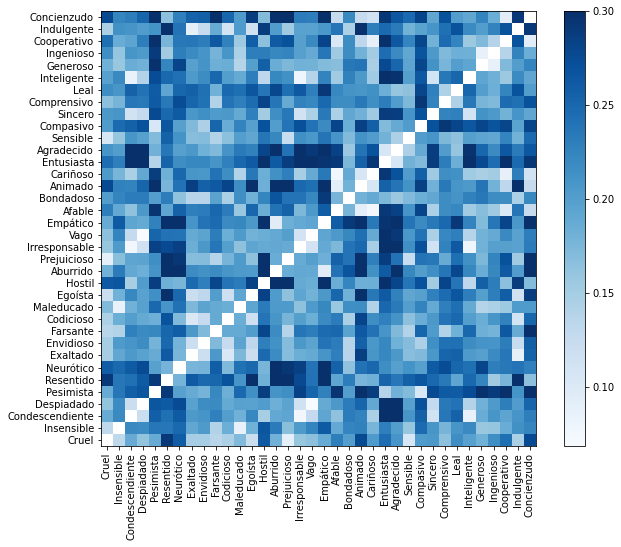

In [10]:
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = .3)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Concept'],)
_ = ax.set_xticklabels(stimuli_table['Concept'],rotation = 90)

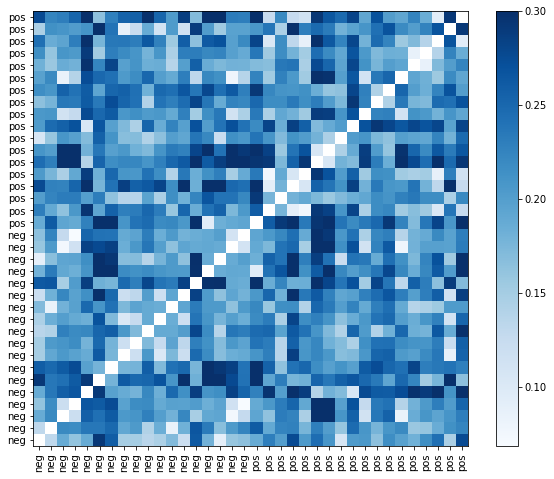

In [11]:
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = .3)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Likableness'],)
_ = ax.set_xticklabels(stimuli_table['Likableness'],rotation = 90)

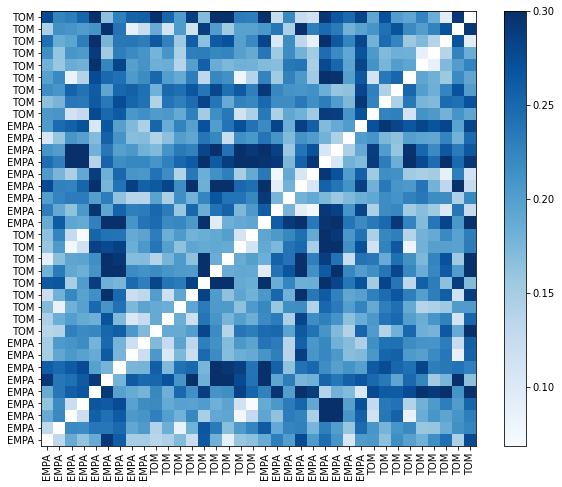

In [12]:
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(RDM,
               origin = "lower",
               cmap = plt.cm.Blues,
               vmax = .3)
plt.colorbar(im)
_ = ax.set(xticks = np.arange(RDM.shape[0]),
           yticks = np.arange(RDM.shape[1]),
           yticklabels = stimuli_table['Condition'],)
_ = ax.set_xticklabels(stimuli_table['Condition'],rotation = 90)